In [2]:
import sys
import time

In [3]:
import numpy as np
import pandas as pd
#import jax.numpy as np
#import jaxopt

In [4]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

from sklearn.model_selection import train_test_split

from sklearn.random_projection import GaussianRandomProjection

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import hamming_loss

In [5]:
import matplotlib.pyplot as plt

In [6]:
from scipy.special import expit
from scipy.optimize import minimize as sp_minimize

TODO:
- //(softmax temperature ?)
- //feedback = nb de match entre predictions et labels (par ligne)
- //model : fix feature map : phi(X,A)(i,j) = X[i,j]*sign(A[i,j])
- (NTH) provide gradients to optim
- make sure loss is good
- fix pi0 to be bad

---
## Loading dataset

In [7]:
dataset_name='scene'
# dataset_name='yeast'
#dataset_name='tmc2007'

In [8]:
X_train, y_train_ = load_svmlight_file(dataset_name+'_train.svm', multilabel=True)
X_train = np.array(X_train.todense())
X_train.shape

(1211, 294)

In [9]:
X_test, y_test_ = load_svmlight_file(dataset_name+'_test.svm', multilabel=True)
X_test = np.array(X_test.todense())
X_test.shape

(1196, 294)

In [10]:
onehot_labeller = MultiLabelBinarizer()
y_train = onehot_labeller.fit_transform(y_train_).astype(int)
y_test = onehot_labeller.transform(y_test_).astype(int)

In [11]:
X_all = np.vstack([X_train, X_test])
y_all = np.vstack([y_train, y_test])
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=.25, random_state=42
)
X_train.shape, X_test.shape

((1805, 294), (602, 294))

In [12]:
if dataset_name == 'tmc_2007':
    print("reducing dimension for TMC dataset")
    fh = GaussianRandomProjection(n_components=1000)
    X_train = fh.fit_transform(X_train)
    X_test = fh.transform(X_test)
    print(X_train.shape)

In [13]:
labels = onehot_labeller.classes_.astype(int)
labels

array([0, 1, 2, 3, 4, 5])

(array([1.67e+03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.34e+02,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

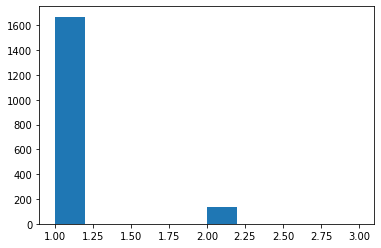

In [14]:
plt.hist(y_train.sum(axis=1))

FYI: Error rate of null policy (always predict 0)

In [15]:
y_test.sum()/(y_test.shape[0])

1.069767441860465

---
## Our Model

### CRM routines

In [16]:
class CRMDataset(object):
    
    def __init__(self):

        self.propensities_ = []
        self.actions_ = []
        self.rewards_ = []
        self.features_ = []
        
        self.propensities_np = None
        self.actions_np = None
        self.rewards_np = None
        self.features_np = None

        self.check()
        
    def __str__(self):
        if not self.propensities_np:
            return '<CRMDataset>'
        self._generate_numpys()
        return '<CRMDataset propensities:%s actions:%s rewards:%s features:%s>' % (
            self.propensities_np.shape,
            self.actions_np.shape,
            self.rewards_np.shape,
            self.features_np.shape
        )
    
    __repr__ = __str__
        
    def check(self):
        assert len(self.features_) == len(self.propensities_) == len(self.rewards_) == len(self.actions_)
        assert type(self.propensities_) == type(self.actions_) == type(self.rewards_) == type(self.features_) == list        
        
    def __len__(self):
        return len(self.propensities_)
        
    def _generate_numpys(self):
        if self.propensities_np is not None and len(self.propensities_np) == len(self.propensities_):
            return        
        self.propensities_np = np.vstack(self.propensities_)
        self.actions_np = np.vstack(self.actions_)
        self.rewards_np = np.vstack(self.rewards_)
        self.features_np = np.vstack(self.features_)
        
    @property
    def actions(self):
#         self._generate_numpys()
        return self.actions_np

    @property
    def propensities(self):
#         self._generate_numpys()
        return self.propensities_np
    
    @property
    def rewards(self):
#         self._generate_numpys()
        return self.rewards_np
    
    @property
    def features(self):
#         self._generate_numpys()
        return self.features_np
        
    def update_from_supervised_dataset(self, X, y, probas, n_samples=4, labels=labels):
        # X is (n,d)
        # y is (n,k)
        # probas is (n,k)

        assert len(X) == len(y) == len(probas), (len(X) , len(y) , len(probas))

        for i in range(len(X)):

            for k in range(n_samples):

                chosen_actions = np.array([np.random.binomial(1, p=probas[i,j]) for j in labels])
                self.actions_ += [chosen_actions]
                self.propensities_ += [probas[i,:]]
                self.features_ += [X[i,:]]
                self.rewards_ += [sum(int(y[i,j] == chosen_actions[j]) for j in labels)]
                
        self._generate_numpys()
        return self

### Modeling

In [57]:
class Model(object):
    
    def __init__(self, beta):
        self.d = beta.shape[0]
        self.k = beta.shape[1]
        self.beta_ = beta
        
    @property
    def beta(self):
        return self.beta_
    
    @beta.setter
    def beta(self, beta):
        # beta is (d, k)
        self.beta_ = beta.reshape(self.d, self.k)
        
    @staticmethod
    def random_model(d, k):
        beta = np.random.normal(size=(d, k))
        return Model(beta)
    
    @staticmethod
    def null_model(d, k):
        beta = np.zeros((d, k))
        return Model(beta)

    def predict(self, features):
        wx = np.dot(features, self.beta_)
        return (wx > 0).astype(int)
    
    def predict_proba(self, features, actions):
        wx = np.dot(features, self.beta_)
        actions_sign = 2 * actions - 1
        return expit(actions_sign * wx)
    
    def expected_hamming_loss(self, X, y):
        y_invert = 1 - y
        invert_probas = self.predict_proba(X, y_invert)
        return invert_probas.sum() / (self.k * y.shape[0])    
        
    def crm_loss(self, crm_dataset: CRMDataset, clip: float = 1000, lambda_: float = 0):
        n = crm_dataset.features.shape[0]

        predictions = self.predict_proba(crm_dataset.features, crm_dataset.actions)
        
        predictions[predictions == 0] = 1. # to avoid log(0)
        instances_with_nonzero_proba = (predictions.sum(axis=1) > 0).astype(int)
        
        per_instance_log_predictions = np.log(predictions).sum(axis=1)
        per_instance_log_propensities = np.log(crm_dataset.propensities).sum(axis=1)
        per_instance_log_propensities = np.clip(per_instance_log_propensities, -100, None) #
        per_instance_log_importance_weights = per_instance_log_predictions - per_instance_log_propensities
        
        per_instance_importance_weights = np.exp(per_instance_log_importance_weights)
        per_instance_importance_weights = per_instance_importance_weights * instances_with_nonzero_proba
        per_instance_importance_weights = np.clip(per_instance_importance_weights, 0, clip)
        
        per_instance_importance_weighted_rewards = np.multiply(
            - crm_dataset.rewards, # to make a loss
            per_instance_importance_weights
        )
        
        total_loss = per_instance_importance_weighted_rewards.mean() #sum() / per_instance_importance_weights.sum()
        
        return total_loss / self.k

#         ips_weights = np.ones((n, self.k))
#         non_zero_propensities = np.where(crm_dataset.propensities > 0)
#         ips_weights[non_zero_propensities] = predictions[non_zero_propensities] / crm_dataset.propensities[non_zero_propensities]
#         ips_weights = np.clip(ips_weights, 0, clip)

#         per_instance_weights = ips_weights.sum(axis=1)
#         ips_sum = per_instance_weights.sum()

#         per_instance_weights /= ips_sum

#         per_instance_loss = (self.d - crm_dataset.rewards).flatten()

#         total_loss = np.dot(per_instance_loss, per_instance_weights)

#         if lambda_ > 0:
#             # POEM
#             total_loss += lambda_ * np.std(ips_weights) / np.sqrt(n)

#         return total_loss

### CF Optimization

In [35]:
def iterate_model(model, X, y, sampling_probas, crm_dataset: CRMDataset, 
                  samples_per_instance:int = 4, verbose=1):
        
    # prior_crm_dataset will get extended
    crm_dataset.update_from_supervised_dataset(
        X, y, sampling_probas, 
        n_samples=samples_per_instance
    )
    if verbose:
        print('CRM dataset:', len(crm_dataset), end=' ', file=sys.stderr)
        
    def _loss(beta):
        model.beta = beta
        return model.crm_loss(crm_dataset)
        
    solution = sp_minimize(_loss, model.beta, method='L-BFGS-B')

    model.beta = solution.x
    
    if verbose:
        print(solution.nit, 'steps -> %.3f' % solution.fun, file=sys.stderr)
    
    return model

----
## Baselines & Skylines

 ![Perf from CRM article](./basesky.png)

In [82]:
paper_results = {
    'scene': {
        'pi0': 1.543, 'ips': 1.193, 'poem': 1.168, 'pi*':.659
    },
    'yeast': {
        'pi0': 5.547, 'ips': 4.635, 'poem': 4.480, 'pi*':2.282

    }
}

def stoch_hloss(pi, X_test, y_test):
    predictions = pi.predict_proba(X_test)
    predictions = np.array([_[:,1] for _ in predictions]).T
    idx = np.where(y_test == 0)
    fp = predictions[idx].sum()
    idx = np.where(y_test == 1)
    fn = (1-predictions[idx]).sum()
    return (fn+fp)/(y_test.shape[0]*y_test.shape[1])


def result_table(model: Model, pi0, pistar, X_test, y_test):
    
    stats = paper_results[dataset_name]
    
    print('Baseline -- paper: %.3f -- ours (stoch.): %.3f' % (stats["pi0"]/y_test.shape[1], 
                                                     stoch_hloss(pi0, X_test, y_test)))
    print('Baseline -- paper: %.3f -- ours (deter.): %.3f' % (stats["pi0"]/y_test.shape[1], 
                                                     hamming_loss(y_test, pi0.predict(X_test))))
    print('IPS      -- paper: %.3f -- ours (stoch.): %.3f' % (stats["ips"]/y_test.shape[1], 
                                                     model.expected_hamming_loss(X_test, y_test)))
    print('POEM     -- paper: %.3f' % (stats["poem"]/y_test.shape[1]))
    print('Skyline  -- paper: %.3f -- ours (stoch.): %.3f' % (stats["pi*"]/y_test.shape[1], 
                                                     stoch_hloss(pistar, X_test, y_test)))    
    print('Skyline  -- paper: %.3f -- ours (deter.): %.3f' % (stats["pi*"]/y_test.shape[1], 
                                                     hamming_loss(y_test, pistar.predict(X_test))))    

In [20]:
pistar = MultiOutputClassifier(LogisticRegressionCV(max_iter=10000, n_jobs=6))
pistar.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegressionCV(max_iter=10000, n_jobs=6))

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
from sklearn.neighbors import KNeighborsClassifier

In [75]:
pi0 = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=30),#penalty='l2', C=1e-9, fit_intercept=0, intercept_scaling=0), 
                            n_jobs=6)

X_0, _, y_0, _ = train_test_split(X_train, y_train, test_size=.95, random_state=0)
print('learning pi0 on', len(X_0), 'data points')

pi0.fit(X_0, y_0)

learning pi0 on 90 data points


MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=30), n_jobs=6)

In [83]:
result_table(Model.null_model(X_test.shape[1], y_test.shape[1]), pi0, pistar, X_test, y_test)

Baseline -- paper: 0.257 -- ours (stoch.): 0.244
Baseline -- paper: 0.257 -- ours (deter.): 0.180
IPS      -- paper: 0.199 -- ours (stoch.): 0.500
POEM     -- paper: 0.195
Skyline  -- paper: 0.110 -- ours (stoch.): 0.129
Skyline  -- paper: 0.110 -- ours (deter.): 0.079


---
## Sequential CRM

### Tracing

In [25]:
class LossHistory(object):
    
    def __init__(self, name, ref_crm_dataset, X_test, y_test):
        self.name = name
        self.ref_crm_dataset = ref_crm_dataset
        self.X_test = X_test
        self.y_test = y_test
        self.hamming_loss = []
        self.crm_loss = []
        self.unif_crm_loss = []
        self.betas = []
        self.n_samples = []
        self.n_actions = []
        self.rewards = []
        
    def update(self, model: Model, crm_dataset: CRMDataset):
        self.betas += [model.beta]
        self.hamming_loss += [model.expected_hamming_loss(self.X_test, self.y_test)]
        self.crm_loss += [model.crm_loss(crm_dataset)]
        self.unif_crm_loss += [model.crm_loss(self.ref_crm_dataset)]
        self.n_samples += [len(crm_dataset)]
        self.n_actions += [np.sum(crm_dataset.actions_)]
        self.rewards += [np.sum(crm_dataset.rewards_)]
        
    def show_last(self):
        print(
            '<', self.name,
            'Ham. loss: %.5f' % self.hamming_loss[-1], 
            'CRM loss: %.5f' % self.crm_loss[-1],
            'CRM loss (U): %.5f' % self.unif_crm_loss[-1],
            '|beta|=%.2f' % np.sqrt((self.betas[-1]**2).sum()), 
            'n=%d' % self.n_samples[-1],
            '|A|=%d' % self.n_actions[-1],
            '|R|=%d' % self.rewards[-1],
            '>',
            file=sys.stderr
        )

In [26]:
ref_crm_dataset = CRMDataset().update_from_supervised_dataset(
    X_train, y_train, 
    np.ones((X_train.shape[0], y_train.shape[1]))*.5,
    n_samples=40
)

In [80]:
random_model = Model.random_model(X_test.shape[1], y_test.shape[1])
print('beta0 Exp. H. loss: %.3f' % random_model.expected_hamming_loss(X_test, y_test))
print('beta0 CRM Loss (unif): %.3f' % random_model.crm_loss(ref_crm_dataset))

beta0 Exp. H. loss: 0.431
beta0 CRM Loss (unif): -0.518


### The Experiment

In [87]:
static_model = Model.random_model(X_test.shape[1], y_test.shape[1])
dynamic_model = Model.random_model(X_test.shape[1], y_test.shape[1])

static_crm_dataset = CRMDataset()
dynamic_crm_dataset = CRMDataset()

static_loss_history = LossHistory("Static", ref_crm_dataset, X_test, y_test)
dynamic_loss_history = LossHistory("Dynamic", ref_crm_dataset, X_test, y_test)

epochs = 1
n_episods = 1
batch = int(len(X_train) / n_episods)
replays = 4

t_end = t_start = time.time()
for _ in range(epochs):
    
    print('*'*30, 'PASS %d/%d'% (_+1, epochs), '*'*30, file=sys.stderr)
    for episod in range(n_episods):
        
        t_end = time.time()
        start = episod*batch
        end = (episod+1)*batch
        print('*'*20, 'episod: %d/%d' % (episod+1, n_episods), 
              'time: %ds' % (t_end - t_start), '*'*20, file=sys.stderr)
        t_start = time.time()

        # current slice of dataset
        X = X_train[start:end,:]
        y = y_train[start:end,:]
       
        #### static CRM 
        ## action probas
        sampling_probas_static = pi0.predict_proba(X)
        sampling_probas_static = np.array([_[:,1] for _ in sampling_probas_static]).T
        ## optimize
        iterate_model(
            static_model, X, y, sampling_probas_static, static_crm_dataset, 
            samples_per_instance=replays,
        )
        ## record
        static_loss_history.update(static_model, static_crm_dataset)
        static_loss_history.show_last()
        
        #### sequential CRM 
        ## action probas
#         if episod == 0:
#             sampling_probas_dynamic = sampling_probas_static
#         else:
#             sampling_probas_dynamic = dynamic_model.predict_proba(X, y)        
#         ## optimize
#         iterate_model(
#             dynamic_model, X, y, sampling_probas_dynamic, dynamic_crm_dataset,
#             samples_per_instance=replays,
#         )
#         ## record
#         dynamic_loss_history.update(dynamic_model, dynamic_crm_dataset)
#         dynamic_loss_history.show_last()

****************************** PASS 1/1 ******************************
******************** episod: 1/1 time: 0s ********************
CRM dataset: 7220 /tmp/ipykernel_16602/4268365235.py:50: RuntimeWarning: divide by zero encountered in log
  per_instance_log_propensities = np.log(crm_dataset.propensities).sum(axis=1)


KeyboardInterrupt: 

In [ ]:
result_table(static_model, pi0, pistar, X_test, y_test)

### Insights

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.set_ylabel('CRM Loss')
ax.plot(static_loss_history.crm_loss, '--', label='CRM loss (static)')
ax.plot(dynamic_loss_history.crm_loss, '--', label='CRM loss (dynamic)')
ax.plot(static_loss_history.unif_crm_loss, '--', label='unif. CRM loss (static)')
ax.plot(dynamic_loss_history.unif_crm_loss, '--', label='unif. CRM loss (dynamic)')
ax.legend(loc='upper right')
ax2 = ax.twinx()
ax2.plot(static_loss_history.hamming_loss, label='Hamming loss (static)')
ax2.plot(dynamic_loss_history.hamming_loss, label='Hamming loss (dynamic)')
ax2.set_ylabel('Hamming Loss')
ax2.legend(loc='lower left')

In [ ]:
plt.title('Avg Proba per Action')
plt.plot(expit(beta_static.mean(axis=0)),'--', label='static')
plt.plot(expit(beta_dynamic.mean(axis=0)),'--', label='dynamic')
plt.legend()

In [ ]:
plt.title('Avg Proba per Feature')
plt.plot(expit(beta_static.mean(axis=1)),'--', label='static')
plt.plot(expit(beta_dynamic.mean(axis=1)),'--', label='dynamic')
plt.legend()

In [ ]:
plt.title('Sampling Probas per Action')
plt.plot(sampling_probas_static.mean(axis=0),'--', label='static')
plt.plot(sampling_probas_dynamic.mean(axis=0),'--', label='dynamic')
plt.plot(y_test.mean(axis=0), label='label average', alpha=.5)
plt.legend()